## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp_l1(input_shape, output_units=10, num_neurons=[521, 256, 128], l1_ratio=1e-4):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1_L2=[1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
results = {}
"""
Set your training loop
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session()
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 521)               1601033   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               133632    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,768,851
Trainable params: 1,768,851
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 144us/step - loss: 6.0730 - acc: 0.2709 - val_loss: 5.8747 - val_acc: 0.3458
Epoch 2/50
50000/50000 [==============================] - 7s 140us/step - loss: 5.7871 - acc: 0.3642 - val_loss: 5.7045 - val_acc: 0.3841
Epoch 3/50
50000/50000 [==============================] - 7s 148us/step - loss: 5.6394 - acc: 0.3947 - val_loss: 5.5962 - val_acc: 0.3898
Epoch 4/50
50000/50000 [==============================] - 8s 160us/step - loss: 5.5186 - acc: 0.4122 - val_loss: 5.4730 - val_acc: 0.4115
Epoch 5/50
50000/50000 [==============================] - 8s 161us/step - loss: 5.4081 - acc: 0.4294 - val_loss: 5.3573 - val_acc: 0.4377
Epoch 6/50
50000/50000 [==============================] - 8s 151us/step - loss: 5.3051 - acc: 0.4433 - val_loss: 5.2728 - val_acc: 0.4370
Epoch 7/50
50000/50000 [==============================] - 9s 175us/step - loss: 5.2096 - acc: 0.4529 - val_loss: 5.1760 - 

Epoch 2/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.7878 - acc: 0.3712 - val_loss: 1.7372 - val_acc: 0.3964
Epoch 3/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.7058 - acc: 0.4014 - val_loss: 1.6819 - val_acc: 0.4122
Epoch 4/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.6495 - acc: 0.4236 - val_loss: 1.6374 - val_acc: 0.4304
Epoch 5/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.6058 - acc: 0.4365 - val_loss: 1.6041 - val_acc: 0.4362
Epoch 6/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.5685 - acc: 0.4503 - val_loss: 1.5673 - val_acc: 0.4463
Epoch 7/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.5369 - acc: 0.4614 - val_loss: 1.5429 - val_acc: 0.4551
Epoch 8/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.5081 - acc: 0.4716 - val_loss: 1.5514 - val_acc: 0.4510
Epoch 9/50
50000/50000 [==========

50000/50000 [==============================] - 7s 137us/step - loss: 1.7129 - acc: 0.4022 - val_loss: 1.6843 - val_acc: 0.4048
Epoch 4/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.6507 - acc: 0.4231 - val_loss: 1.6280 - val_acc: 0.4280
Epoch 5/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.6026 - acc: 0.4369 - val_loss: 1.5870 - val_acc: 0.4435
Epoch 6/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.5620 - acc: 0.4544 - val_loss: 1.5669 - val_acc: 0.4491
Epoch 7/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.5277 - acc: 0.4643 - val_loss: 1.5355 - val_acc: 0.4602
Epoch 8/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.4991 - acc: 0.4766 - val_loss: 1.5096 - val_acc: 0.4653
Epoch 9/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.4694 - acc: 0.4846 - val_loss: 1.4890 - val_acc: 0.4752
Epoch 10/50
50000/50000 [====================

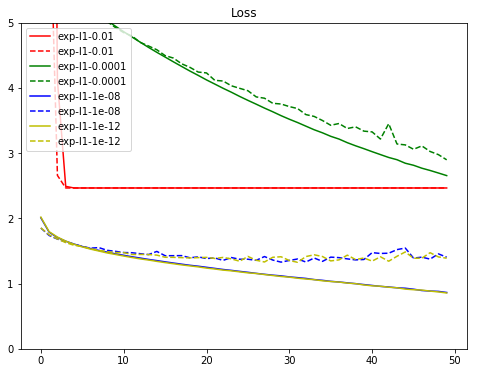

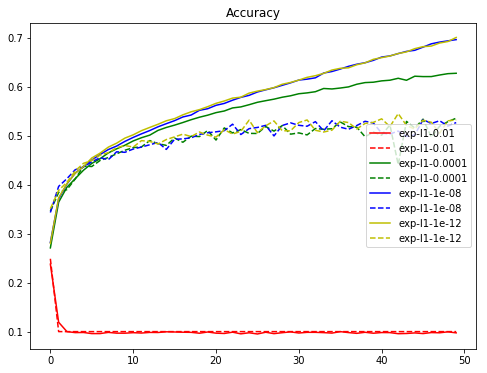

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [12]:
results = {}
for regulizer_ratio in L1_L2:
    keras.backend.clear_session()
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 149us/step - loss: 18.8326 - acc: 0.2598 - val_loss: 17.3745 - val_acc: 0.3377
Epoch 2/50
50000/50000 [==============================] - 7s 139us/step - loss: 16.1518 - acc: 0.3551 - val_loss: 14.9841 - val_acc: 0.3726
Epoch 3/50
50000/50000 [==============================] - 7s 140us/step - loss: 13.9611 - acc: 0.3814 - val_loss: 12.9797 - val_acc: 0.3931
Epoch 4/50
50000/50000 [==============================] - 7s 139us/step - loss: 12.1107 - acc: 0.3961 - val_loss: 11.2774 - val_acc: 0.4033
Epoch 5/50
50000/50000 [==============================] - 7s 140us/step - loss: 10.5387 - acc: 0.4057 - val_loss: 9.8410 - val_acc: 0.4050
Epoch 6/50
50000/50000 [==============================] - 7s 143us/step - loss: 9.2021 - acc: 0.4123 - val_loss: 8.6013 - val_acc: 0.4178
Epoch 7/50
50000/50000 [==============================] - 8s 154us/step - loss: 8.0629 - acc: 0.4177 - val_loss: 

Epoch 2/50
50000/50000 [==============================] - 8s 153us/step - loss: 13.0212 - acc: 0.3562 - val_loss: 12.1300 - val_acc: 0.3712
Epoch 3/50
50000/50000 [==============================] - 8s 153us/step - loss: 11.3482 - acc: 0.3799 - val_loss: 10.5939 - val_acc: 0.3903
Epoch 4/50
50000/50000 [==============================] - 8s 154us/step - loss: 9.9332 - acc: 0.3977 - val_loss: 9.2992 - val_acc: 0.3996
Epoch 5/50
50000/50000 [==============================] - 8s 155us/step - loss: 8.7315 - acc: 0.4073 - val_loss: 8.1876 - val_acc: 0.4123
Epoch 6/50
50000/50000 [==============================] - 8s 154us/step - loss: 7.7090 - acc: 0.4165 - val_loss: 7.2481 - val_acc: 0.4147
Epoch 7/50
50000/50000 [==============================] - 8s 155us/step - loss: 6.8376 - acc: 0.4218 - val_loss: 6.4551 - val_acc: 0.4146
Epoch 8/50
50000/50000 [==============================] - 8s 156us/step - loss: 6.0936 - acc: 0.4279 - val_loss: 5.7575 - val_acc: 0.4307
Epoch 9/50
50000/50000 [======

50000/50000 [==============================] - 8s 155us/step - loss: 11.3759 - acc: 0.3739 - val_loss: 10.6272 - val_acc: 0.3785
Epoch 4/50
50000/50000 [==============================] - 7s 149us/step - loss: 9.9617 - acc: 0.3882 - val_loss: 9.3246 - val_acc: 0.3852
Epoch 5/50
50000/50000 [==============================] - 8s 161us/step - loss: 8.7588 - acc: 0.3998 - val_loss: 8.2124 - val_acc: 0.3980
Epoch 6/50
50000/50000 [==============================] - 8s 163us/step - loss: 7.7328 - acc: 0.4072 - val_loss: 7.2713 - val_acc: 0.4094
Epoch 7/50
50000/50000 [==============================] - 8s 166us/step - loss: 6.8588 - acc: 0.4150 - val_loss: 6.4607 - val_acc: 0.4198
Epoch 8/50
50000/50000 [==============================] - 7s 148us/step - loss: 6.1134 - acc: 0.4198 - val_loss: 5.7734 - val_acc: 0.4208
Epoch 9/50
50000/50000 [==============================] - 8s 164us/step - loss: 5.4748 - acc: 0.4247 - val_loss: 5.1925 - val_acc: 0.4309
Epoch 10/50
50000/50000 [==================

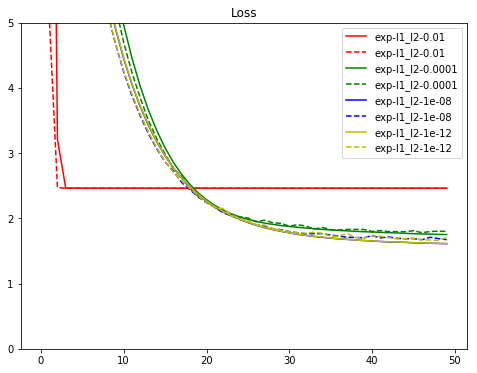

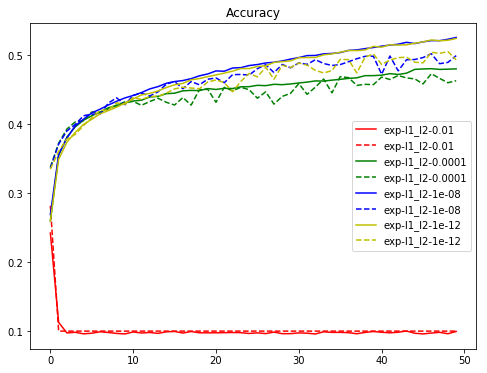

In [13]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()